# Generate a top-n list of restaurants on consumer preference - Restaurant & Consumer data

# Abstract:

The dataset was obtained from a recommender system prototype. The task was to generate a top-n list of restaurants according to 
the consumer preferences.

The collaborative filter technique used only one file i.e., rating_final.csv that comprises the user, item and rating attributes

# Dataset:

https://archive.ics.uci.edu/ml/machine-learning-databases/00232/

(In here you will find rating_final.csv inside RCdata folder to be used)

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Import required libraries
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
#Data Import
#Read and explore the dataset. ( Rename column, plot histograms, find data characteristics)
#Import the data set
df = pd.read_csv('rating_final.csv')#, header=None)

In [5]:
df.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


In [6]:
# Check the number of rows and columns
rows, columns = df.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  1161
No of columns:  5


In [7]:
#Check Data types
df.dtypes

userID            object
placeID            int64
rating             int64
food_rating        int64
service_rating     int64
dtype: object

In [8]:
# Check for missing values present
print('Number of missing values across columns-\n', df.isnull().sum())

Number of missing values across columns-
 userID            0
placeID           0
rating            0
food_rating       0
service_rating    0
dtype: int64


There are no missing values with total records 1161

In [9]:
# Summary statistics of 'rating' variable
df['rating'].describe().transpose()

count    1161.000000
mean        1.199828
std         0.773282
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: rating, dtype: float64

In [10]:
# find minimum and maximum ratings
print('The minimum rating is: %d' %(df['rating'].min()))
print('The maximum rating is: %d' %(df['rating'].max()))

The minimum rating is: 0
The maximum rating is: 2


Ratings are on scale of 0 - 2

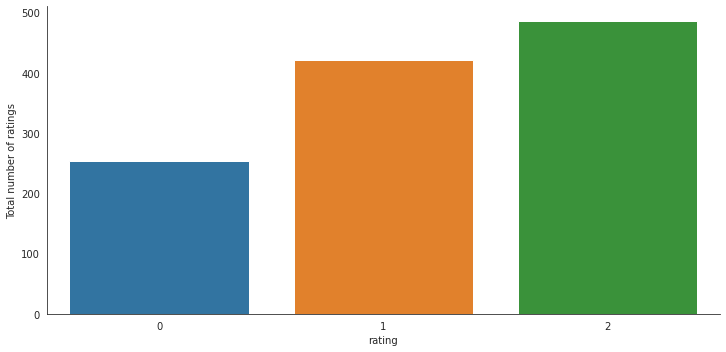

In [11]:
# Check the distribution of ratings 
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings") 

In [12]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['userID'].nunique())
print('Number of unique PLACES in Raw data = ', df['placeID'].nunique())

Number of unique USERS in Raw data =  138
Number of unique PLACES in Raw data =  130


Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 12 or more number of 
ratings)

In [13]:
# Top 10 users based on rating
most_rated = df.groupby('userID').size().sort_values(ascending=False)[:10]
most_rated

userID
U1061    18
U1106    18
U1134    16
U1024    15
U1022    14
U1089    14
U1137    14
U1135    14
U1003    13
U1016    13
dtype: int64

Data model preparation as per requirement on number of minimum ratings

In [14]:
counts = df['userID'].value_counts()
print(counts)
df_final = df[df['userID'].isin(counts[counts >= 12].index)]

U1106    18
U1061    18
U1134    16
U1024    15
U1022    14
         ..
U1047     3
U1107     3
U1017     3
U1031     3
U1074     3
Name: userID, Length: 138, dtype: int64


In [15]:
print('Number of users who have rated 12 or more places =', len(df_final))
print('Number of unique USERS in final data = ', df_final['userID'].nunique())
print('Number of unique PLACES in final data = ', df_final['placeID'].nunique())

Number of users who have rated 12 or more places = 273
Number of unique USERS in final data =  20
Number of unique PLACES in final data =  71


df_final has users who have rated 12 or more places

Calculate the density of the rating matrix

In [16]:
final_ratings_matrix = df_final.pivot(index = 'userID', columns ='placeID', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (20, 71)
given_num_of_ratings =  232
possible_num_of_ratings =  1420
density: 16.34%


In [17]:
final_ratings_matrix.head()

placeID,132572,132723,132754,132755,132825,132830,132834,132856,132861,132862,132872,132875,132884,132885,132921,132922,132937,132951,132954,132955,132958,135025,135026,135027,135028,135030,135032,135033,135034,135038,135039,135040,135041,135042,135044,135045,135046,135047,135048,135049,135050,135051,135052,135053,135054,135055,135057,135058,135059,135060,135062,135063,135064,135065,135066,135069,135070,135071,135072,135073,135074,135075,135076,135079,135080,135081,135082,135085,135086,135106,135108
userID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
U1003,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
U1016,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0
U1022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U1024,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
U1036,0.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [18]:
# Matrix with one row per 'Product' and one column per 'user' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

userID,U1003,U1016,U1022,U1024,U1036,U1053,U1061,U1071,U1075,U1088,U1089,U1097,U1098,U1104,U1106,U1112,U1122,U1134,U1135,U1137
placeID,,,,,,,,,,,,,,,,,,,,
132572,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
132723,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
132754,2.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0
132755,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
132825,2.0,0.0,0.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0


In [19]:
#Split the data randomnly into test and train datasets
#Split the training and test data in the ratio 70:30
train_data, test_data = train_test_split(df_final, test_size = 0.3, random_state=0)
train_data.head()

,userID,placeID,rating,food_rating,service_rating
815,U1089,135028,1,1,1
948,U1112,135064,0,1,1
530,U1106,135085,2,2,2
962,U1061,132958,2,2,2
233,U1088,135070,2,2,1


In [20]:
train_data.shape
test_data.shape

(191, 5)

(82, 5)

# Build Popularity Recommender model. (Non-personalised)

In [22]:
#Count of user_id for each unique place as recommendation score 
train_data_grouped = train_data.groupby('placeID').agg({'userID': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userID': 'score'},inplace=True)
train_data_grouped.head()

,placeID,score
0,132572,2
1,132723,2
2,132754,7
3,132825,8
4,132830,2


In [23]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'placeID'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,placeID,score,Rank
3,132825,8,1.0
5,132834,8,2.0
60,135085,8,3.0
2,132754,7,4.0
44,135062,7,5.0


In [0]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userID'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [25]:
find_recom = [13,120,57]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: 13

    userID  placeID  score  Rank
3       13   132825      8   1.0
5       13   132834      8   2.0
60      13   135085      8   3.0
2       13   132754      7   4.0
44      13   135062      7   5.0


Here is the recommendation for the userId: 120

    userID  placeID  score  Rank
3      120   132825      8   1.0
5      120   132834      8   2.0
60     120   135085      8   3.0
2      120   132754      7   4.0
44     120   135062      7   5.0


Here is the recommendation for the userId: 57

    userID  placeID  score  Rank
3       57   132825      8   1.0
5       57   132834      8   2.0
60      57   135085      8   3.0
2       57   132754      7   4.0
44      57   135062      7   5.0




Since this is a popularity-based recommender model, recommendations remain the same for all users

We predict the products based on the popularity. It is not personalized to particular user

# Build Collaborative Filtering model.

Model-based Collaborative Filtering: Singular Value Decomposition

In [26]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.head()

,index,userID,placeID,rating,food_rating,service_rating
0,815,U1089,135028,1,1,1
1,948,U1112,135064,0,1,1
2,530,U1106,135085,2,2,2
3,962,U1061,132958,2,2,2
4,233,U1088,135070,2,2,1


In [27]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df = df_CF.pivot(index = 'userID', columns ='placeID', values = 'rating').fillna(0)
pivot_df.shape
pivot_df.head()

(20, 71)

placeID,132572,132723,132754,132755,132825,132830,132834,132856,132861,132862,132872,132875,132884,132885,132921,132922,132937,132951,132954,132955,132958,135025,135026,135027,135028,135030,135032,135033,135034,135038,135039,135040,135041,135042,135044,135045,135046,135047,135048,135049,135050,135051,135052,135053,135054,135055,135057,135058,135059,135060,135062,135063,135064,135065,135066,135069,135070,135071,135072,135073,135074,135075,135076,135079,135080,135081,135082,135085,135086,135106,135108
userID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
U1003,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
U1016,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0
U1022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U1024,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
U1036,0.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [28]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

placeID,132572,132723,132754,132755,132825,132830,132834,132856,132861,132862,132872,132875,132884,132885,132921,132922,132937,132951,132954,132955,132958,135025,135026,135027,135028,135030,135032,135033,135034,135038,135039,135040,135041,135042,135044,135045,135046,135047,135048,135049,135050,135051,135052,135053,135054,135055,135057,135058,135059,135060,135062,135063,135064,135065,135066,135069,135070,135071,135072,135073,135074,135075,135076,135079,135080,135081,135082,135085,135086,135106,135108,user_index
userID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
U1003,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0
U1016,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,1
U1022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
U1024,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3
U1036,0.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4


In [29]:
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

placeID,132572,132723,132754,132755,132825,132830,132834,132856,132861,132862,132872,132875,132884,132885,132921,132922,132937,132951,132954,132955,132958,135025,135026,135027,135028,135030,135032,135033,135034,135038,135039,135040,135041,135042,135044,135045,135046,135047,135048,135049,135050,135051,135052,135053,135054,135055,135057,135058,135059,135060,135062,135063,135064,135065,135066,135069,135070,135071,135072,135073,135074,135075,135076,135079,135080,135081,135082,135085,135086,135106,135108
user_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


# SVD method

SVD is best to apply on a large sparse matrix

In [0]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

Note that for sparse matrices, you can use the sparse.linalg.svds() function to perform the decomposition.
SVD is useful in many tasks, such as data compression, noise reduction similar to Principal Component Analysis and Latent 
Semantic Indexing (LSI), used in document retrieval and word similarity in Text mining

In [31]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

placeID,132572,132723,132754,132755,132825,132830,132834,132856,132861,132862,132872,132875,132884,132885,132921,132922,132937,132951,132954,132955,132958,135025,135026,135027,135028,135030,135032,135033,135034,135038,135039,135040,135041,135042,135044,135045,135046,135047,135048,135049,135050,135051,135052,135053,135054,135055,135057,135058,135059,135060,135062,135063,135064,135065,135066,135069,135070,135071,135072,135073,135074,135075,135076,135079,135080,135081,135082,135085,135086,135106,135108
0,0.069906,1.906574,1.832744,1.766762,2.095202,0.083452,-0.040606,0.042757,0.250131,1.121656,-0.137579,-0.105791,0.158381,0.196084,0.056008,1.537362,1.537362,0.123609,0.068794,-0.002225,-0.002225,-0.377254,0.000848,0.059377,0.105184,-0.263697,-0.107493,-0.176017,-0.002225,0.265322,0.437256,0.0,-0.019196,0.266402,0.134287,-0.046147,0.534563,-0.136355,0.139812,0.087363,0.166904,-0.130155,-0.277716,-0.223024,-0.101881,0.268573,0.206813,-0.209710,2.041538,0.240130,-0.131344,0.150275,0.196064,0.236785,-0.083863,-0.050941,-0.101881,0.0,-0.105791,0.150226,0.268573,2.175147,0.142305,1.977013,1.811460,-0.016688,-0.101881,-0.099182,-0.072131,-0.202576,-0.101881
1,-0.073168,-0.021583,-0.324434,0.124754,0.317473,0.039750,2.013859,1.283860,0.276230,1.698214,0.033725,0.038332,0.420724,0.104097,0.185357,-0.261952,-0.261952,0.425038,-0.112318,-0.078300,-0.078300,-0.076093,-0.025926,0.139173,0.285284,0.299866,1.794224,0.323551,-0.078300,0.459152,0.465626,0.0,0.221581,1.094104,-0.057076,2.288741,-0.083224,-0.397409,-0.146336,0.454742,0.079500,2.056004,2.036369,-0.305664,0.104951,-0.114153,0.721558,0.028593,0.248866,1.454221,1.674026,0.217703,0.270704,-0.118760,1.368005,0.052476,0.104951,0.0,0.038332,0.728755,-0.114153,-0.135735,-0.105046,0.349484,-0.465365,-0.276867,0.104951,1.999272,-0.005132,1.321721,0.104951
2,0.070248,0.001385,0.182692,-0.139110,0.136370,0.103413,0.210121,0.401623,-0.144801,-0.208554,0.029756,-0.040882,-0.286306,-0.016054,-0.134523,0.090849,0.090849,-0.270842,0.084149,0.027803,0.027803,0.145715,0.008125,0.156803,-0.446484,-0.508850,1.339966,0.491301,0.027803,1.681748,-0.041974,0.0,-0.062334,0.150734,-0.011239,2.237309,0.031716,0.215690,0.140495,-0.342652,0.206825,1.825434,1.664856,0.271818,-0.180851,-0.022477,1.272888,-0.012689,0.016046,1.520440,0.877707,1.298456,-0.240908,0.048161,0.476545,-0.090426,-0.180851,0.0,-0.040882,1.313291,-0.022477,-0.021092,0.363761,-0.242561,0.220106,0.326859,-0.180851,-0.035906,-0.042445,0.746385,-0.180851
3,0.087705,0.044219,0.303906,-0.131192,0.579619,0.110981,0.755020,0.724635,-0.004695,0.716915,-0.073288,-0.015804,-0.305361,0.053068,0.028719,0.118753,0.118753,-0.265749,0.119995,0.064580,0.064580,0.472607,0.118772,0.177417,0.723100,0.719159,1.563958,0.175672,0.064580,0.477306,1.138284,0.0,0.702011,0.669781,-0.065768,0.997736,0.009238,-0.056200,0.175411,-0.360776,0.221962,1.015550,1.054991,-0.177616,0.135199,-0.131536,0.603167,-0.096414,-0.211778,0.906012,0.474021,0.697525,0.043134,-0.189020,0.611092,0.067599,0.135199,0.0,-0.015804,0.491023,-0.131536,-0.087316,0.217312,0.224604,0.228396,0.169280,0.135199,0.133601,-0.023126,0.455764,0.135199
4,0.048680,0.117683,1.766994,0.020322,1.620876,-0.232192,0.986707,0.500834,-0.115555,0.564482,0.174981,0.067134,-0.061761,0.018102,-0.028841,0.006203,0.006203,0.081253,0.021481,-0.054399,-0.054399,1.340296,0.077616,0.025475,0.394501,0.718511,0.443962,0.230466,-0.054399,0.327449,-0.111542,0.0,-0.203234,1.273150,0.308844,1.280987,0.684472,0.448885,0.097360,-0.137641,-0.464383,-0.055057,1.616154,-0.045521,-0.264238,0.617689,-0.418869,0.071901,1.452152,0.509386,0.306474,0.420492,1.610311,0.725536,-0.060847,-0.132119,-0.264238,0.0,0.067134,0.203108,0.617689,0.735372,-0.465187,1.167906,0.412408,-0.365919,-0.264238,2.218019,-0.103080,0.263739,-0.264238


In [0]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [37]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 7
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 7):

                   user_ratings  user_predictions
Recommended Items                                
135049                      0.0          0.408883
135039                      0.0          0.389242
135059                      0.0          0.341844
135057                      0.0          0.318005
135045                      0.0          0.266931


Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (RMSE) on 
predictions made on the test data.)

Evaluation of Model-based Collaborative Filtering (SVD)

In [38]:
# Actual ratings given by the users
final_ratings_matrix.head()

placeID,132572,132723,132754,132755,132825,132830,132834,132856,132861,132862,132872,132875,132884,132885,132921,132922,132937,132951,132954,132955,132958,135025,135026,135027,135028,135030,135032,135033,135034,135038,135039,135040,135041,135042,135044,135045,135046,135047,135048,135049,135050,135051,135052,135053,135054,135055,135057,135058,135059,135060,135062,135063,135064,135065,135066,135069,135070,135071,135072,135073,135074,135075,135076,135079,135080,135081,135082,135085,135086,135106,135108
userID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
U1003,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
U1016,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0
U1022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U1024,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
U1036,0.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [39]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

placeID
132572    0.05
132723    0.30
132754    0.70
132755    0.20
132825    0.70
dtype: float64

In [40]:
# Predicted ratings 
preds_df.head()

placeID,132572,132723,132754,132755,132825,132830,132834,132856,132861,132862,132872,132875,132884,132885,132921,132922,132937,132951,132954,132955,132958,135025,135026,135027,135028,135030,135032,135033,135034,135038,135039,135040,135041,135042,135044,135045,135046,135047,135048,135049,135050,135051,135052,135053,135054,135055,135057,135058,135059,135060,135062,135063,135064,135065,135066,135069,135070,135071,135072,135073,135074,135075,135076,135079,135080,135081,135082,135085,135086,135106,135108
0,0.069906,1.906574,1.832744,1.766762,2.095202,0.083452,-0.040606,0.042757,0.250131,1.121656,-0.137579,-0.105791,0.158381,0.196084,0.056008,1.537362,1.537362,0.123609,0.068794,-0.002225,-0.002225,-0.377254,0.000848,0.059377,0.105184,-0.263697,-0.107493,-0.176017,-0.002225,0.265322,0.437256,0.0,-0.019196,0.266402,0.134287,-0.046147,0.534563,-0.136355,0.139812,0.087363,0.166904,-0.130155,-0.277716,-0.223024,-0.101881,0.268573,0.206813,-0.209710,2.041538,0.240130,-0.131344,0.150275,0.196064,0.236785,-0.083863,-0.050941,-0.101881,0.0,-0.105791,0.150226,0.268573,2.175147,0.142305,1.977013,1.811460,-0.016688,-0.101881,-0.099182,-0.072131,-0.202576,-0.101881
1,-0.073168,-0.021583,-0.324434,0.124754,0.317473,0.039750,2.013859,1.283860,0.276230,1.698214,0.033725,0.038332,0.420724,0.104097,0.185357,-0.261952,-0.261952,0.425038,-0.112318,-0.078300,-0.078300,-0.076093,-0.025926,0.139173,0.285284,0.299866,1.794224,0.323551,-0.078300,0.459152,0.465626,0.0,0.221581,1.094104,-0.057076,2.288741,-0.083224,-0.397409,-0.146336,0.454742,0.079500,2.056004,2.036369,-0.305664,0.104951,-0.114153,0.721558,0.028593,0.248866,1.454221,1.674026,0.217703,0.270704,-0.118760,1.368005,0.052476,0.104951,0.0,0.038332,0.728755,-0.114153,-0.135735,-0.105046,0.349484,-0.465365,-0.276867,0.104951,1.999272,-0.005132,1.321721,0.104951
2,0.070248,0.001385,0.182692,-0.139110,0.136370,0.103413,0.210121,0.401623,-0.144801,-0.208554,0.029756,-0.040882,-0.286306,-0.016054,-0.134523,0.090849,0.090849,-0.270842,0.084149,0.027803,0.027803,0.145715,0.008125,0.156803,-0.446484,-0.508850,1.339966,0.491301,0.027803,1.681748,-0.041974,0.0,-0.062334,0.150734,-0.011239,2.237309,0.031716,0.215690,0.140495,-0.342652,0.206825,1.825434,1.664856,0.271818,-0.180851,-0.022477,1.272888,-0.012689,0.016046,1.520440,0.877707,1.298456,-0.240908,0.048161,0.476545,-0.090426,-0.180851,0.0,-0.040882,1.313291,-0.022477,-0.021092,0.363761,-0.242561,0.220106,0.326859,-0.180851,-0.035906,-0.042445,0.746385,-0.180851
3,0.087705,0.044219,0.303906,-0.131192,0.579619,0.110981,0.755020,0.724635,-0.004695,0.716915,-0.073288,-0.015804,-0.305361,0.053068,0.028719,0.118753,0.118753,-0.265749,0.119995,0.064580,0.064580,0.472607,0.118772,0.177417,0.723100,0.719159,1.563958,0.175672,0.064580,0.477306,1.138284,0.0,0.702011,0.669781,-0.065768,0.997736,0.009238,-0.056200,0.175411,-0.360776,0.221962,1.015550,1.054991,-0.177616,0.135199,-0.131536,0.603167,-0.096414,-0.211778,0.906012,0.474021,0.697525,0.043134,-0.189020,0.611092,0.067599,0.135199,0.0,-0.015804,0.491023,-0.131536,-0.087316,0.217312,0.224604,0.228396,0.169280,0.135199,0.133601,-0.023126,0.455764,0.135199
4,0.048680,0.117683,1.766994,0.020322,1.620876,-0.232192,0.986707,0.500834,-0.115555,0.564482,0.174981,0.067134,-0.061761,0.018102,-0.028841,0.006203,0.006203,0.081253,0.021481,-0.054399,-0.054399,1.340296,0.077616,0.025475,0.394501,0.718511,0.443962,0.230466,-0.054399,0.327449,-0.111542,0.0,-0.203234,1.273150,0.308844,1.280987,0.684472,0.448885,0.097360,-0.137641,-0.464383,-0.055057,1.616154,-0.045521,-0.264238,0.617689,-0.418869,0.071901,1.452152,0.509386,0.306474,0.420492,1.610311,0.725536,-0.060847,-0.132119,-0.264238,0.0,0.067134,0.203108,0.617689,0.735372,-0.465187,1.167906,0.412408,-0.365919,-0.264238,2.218019,-0.103080,0.263739,-0.264238


In [41]:
# Average PREDICTED rating for each item
preds_df.mean().head()

placeID
132572    0.060458
132723    0.312875
132754    0.718666
132755    0.191959
132825    0.687938
dtype: float64

In [42]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(71, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
placeID,,,
132572,0.05,0.060458,0
132723,0.30,0.312875,1
132754,0.70,0.718666,2
132755,0.20,0.191959,3
132825,0.70,0.687938,4


In [43]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.01868 



Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will 
recommend 5 new products.

In [44]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 20
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 20):

                   user_ratings  user_predictions
Recommended Items                                
135066                      0.0          0.312316
135047                      0.0          0.280690
135106                      0.0          0.261734
132754                      0.0          0.232130
132937                      0.0          0.229400


Summarise your insights.

Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of 
the user and it is not dependent on any additional information.

The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may be 
not suitable to the user.You can see the differance above for the user id 13 & 120, The Popularity based model has recommended 
the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the 
user past purchase history

![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.